# Selección de variables (Feature Selection)

En este notebook veremos los métodos más utilizados para seleccionar variables de nuestro dataframe que nos ayude a focalizar el problema. Pero, ¿por qué seleccionar variables, dónde queda eso de que necesitamos datos y cuantos más datos mejor? Pues sí y no, porque obtendremos mejores resultados cuanta más información **útil** dispongamos para extraer patrones.

Existen dos razones principales por las que hacer selección de variables:
 - **Reducir complejidad coputacional.** Cuantos menos datos tengamos, menor carga tendrá que soportar el modelo, por lo que podrá realizar los cálculos mucho más rápido, y necesitaremos menores recursos para implementarlo.
 - **Reducir overfitting.** Algunos algoritmos se ven afectados por las variables que no aportan información para predecir la variable objetivo, ya que generan ruido y favorecen que el resultado sea menos preciso, pues el algoritmo no es capaz de detectar que no es información útil y hacen overfitting con estas variables

Como hemos visto en la teoría, tenemos diferentes tipos de reducción de variables. Podemos diferenciar 3 tipos diferentes:

 - **Supervisado**: buscamos extraer la información comparando con la varaible objetivo.
 - **No supervisado**: como no tenemos variable objetivo, solo podemos buscar relaciones entre las propias variables
 - **Reducción de dimensionalidad**: buscamos reducir variables creándonos otras que sean combinaciones de las originales. Lo que buscamos aquí consiste en sacar la información mínima necesaria de las variables que tenemos para crearnos un conjunto de menos variables que las originales. Dentro de estos métodos entra nuestro amigo PCA, sobre el cual volveremos mucho más adelante.
 
En este notebook veremos los 2 primeros, que son los que más vamos a utilizar, y que no suponen la pérdida de las variables originales. Para facilitar el seguimiento del notebook, se ha decidido dividirlo con el siguiente formato:
 - Selección basada en estadísticos (no supervisado y supervisado)
 - Selección basada en modelo (Solo supervisado):
   - Intrínseco
   - Wrapper


## Selección basada en estadísticos

La primera opción que se nos viene a la cabeza a la hora de reducir variables, es la eliminación de aquellas varaibles que no presentan cambios, es decir, las constantes, ya que no aportan absolutamente nada de información. Partiendo de esta premisa, es razonable asumir que las características con baja varianza son peores que aquellas con alta varianza. Por lo tanto, se puede considerar que las características con variación por debajo de un cierto umbral no serán útiles para nuestro modelo.

### Basado en estadísticos: No supervisado

Para ello, nos vamos a basar en el objeto de ``sklearn`` llamado ``VarianceThreshold``, y es que para casi todo lo que te puedas imaginar hay un objeto de ``sklearn``. Su tilización será exactamente igual que los que hemos visto hasta la fecha: ``fit`` con los datos y posterior ``transform`` (o ``fit_transform`` directamente). Cuando lo creamos, podemos indicar el umbral que queremos utilizar para mantener o no una variable en nuestro dataset.

Además, utilizaremos la función ``make_classification``, que nos generará automáticamente un dataset aleatorio con un target binario.

Para comprobar el funcionamiento del objeto, utilizaremos el atributo ``shape``, que nos indicará cuántas filas (las mismas siempre) y columnas tiene la salida, pudiendo comprobar que se reducen las columnas.

In [3]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

In [5]:
# Empezamos con un umbral relativamente bajo, 0.7, lo que significa que se eliminarán aquellas variables que tengan una varainza de 0.7 o inferior:
umbral = 0.7

selector_varianza = VarianceThreshold(umbral)
selector_varianza.fit(x_data_generated)
x_transformada = selector_varianza.transform(x_data_generated)

# VarianceThreshold(umbral).fit_transform(x_data_generated).shape

In [8]:
x_transformada.shape

(100, 19)

In [9]:
# Subiendo el umbral de varianza, nos vamos quedando con las variables que varían más, es decir, con aquellas que más información nos aportan:
umbral = 0.8

VarianceThreshold(umbral).fit_transform(x_data_generated).shape

(100, 18)

In [10]:
umbral = 0.9

VarianceThreshold(umbral).fit_transform(x_data_generated).shape

(100, 17)

### Basado en estadísticos: Supervisado (filtrado)

Además de lo que acabamos de ver para el caso "No supervisado", cuando disponemos de un objetivo podemos aplicar otras técnicas. En este caso, lo que vamos a hacer es utilizar la función ``f_classif``, que nos devuelve la relación de cada variable con el objetivo. En el caso de clasificación utilizamos ``f_classif``, mientras que para los modelos de regresión utilizaremos ``f_regression``.

Si te fijas en el código, utilizaremos este objeto como argumento de otro objeto: ``SelectKBest``, que es un objeto que, dada una función de scoring (como es ``f_classif``) y un valor entero ``k``, me devolverá únicamente las ``k`` varaibles con mayor score en base a esa funciónd e scoring. En el ejemplo, nos quedaremos con las 5 variables que mayor relación tienen con el objetivo.

Por si te interesa, existen otras funciones de scoring, como son ``mutual_info_classif`` o ``mutual_info_regression``.

Además, utilizaremos la función ``cross_val_score`` para validar los resultados. Lo que hace esta función es evaluar un modelo haciendo *cross validation* sobre un conjunto de datos, buscando minimizar el error (el valor negativo es porque internamente busca maximizar algo, y queremos que el error sea mínimo).

In [34]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

selector = SelectKBest(f_classif, k=5)
x_data_kbest = selector.fit_transform(x_data_generated, y_data_generated)

var_thresh = VarianceThreshold(.9)
x_data_varth = var_thresh.fit_transform(x_data_generated)

In [35]:
x_data_kbest.shape

(100, 5)

Ahora vamos a comprobar si realmente mejora nuestro modelo o no. Para ello, utilizaremos el mimsmo modelo en todos, que en este caso será una regresión logística:

In [36]:
logit = LogisticRegression(solver='lbfgs', random_state=17)

La métrica "neg_log_loss" cuanto más cercade 0, mejor.

In [37]:
from sklearn.model_selection import cross_val_score

cross_val_score(logit, x_data_generated, y_data_generated, 
                scoring='neg_log_loss', cv=5).mean()

-0.16601013154328337

In [38]:
cross_val_score(logit, x_data_kbest, y_data_generated, 
                scoring='neg_log_loss', cv=5).mean()

-0.12377481156505062

In [39]:
cross_val_score(logit, x_data_varth, y_data_generated, 
                scoring='neg_log_loss', cv=5).mean()

-0.15982873310356321

Como puedes observar, el valor se aproxima más a 0 cuando utilizamos nuestra selección de variables, lo que nos hace suponer que esto realmente funciona, auqnue para comprobarlo deberíamos utilizar un caso real, y no siempre nos va a resultar de utilidad.

### EJERCICIO

Prueba la selección de variables que acabamos de ver con el conjunto de datos del Titanic. En este caso, intenta predecir si se trata de un hombre o de una mujer. Para ello, créate 1 modelo (el que quieras) y ejecútalo con las diferentes combinaciones, haciendo uso de la función ``cross_val_score``, por lo que no será necesario que dividas en train y test:

In [40]:
import pandas as pd

df = pd.read_csv("../../../data/titanic.csv", sep='\t')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  156 non-null    int64  
 1   Survived     156 non-null    int64  
 2   Pclass       156 non-null    int64  
 3   Name         156 non-null    object 
 4   Sex          156 non-null    object 
 5   Age          126 non-null    float64
 6   SibSp        156 non-null    int64  
 7   Parch        156 non-null    int64  
 8   Ticket       156 non-null    object 
 9   Fare         156 non-null    float64
 10  Cabin        31 non-null     object 
 11  Embarked     155 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 14.8+ KB


In [42]:
# El que queda de Embarked, lo vamos a rellenar con "S" porque es el mayoritario.
df['Embarked'] = df['Embarked'].fillna('S')

# En Age, vamos a completar los valores nulos con la media de los valores de Age.
df['Age'] = df['Age'].fillna(df['Age'].mean())

# En Pclass, vamos a convertirlo a string para luego hacer el One Hot Encoding.
df['Pclass'] = df['Pclass'].astype(str)

# Separamos las variables que podemos utilizar para predecir de la que queremos predecir:
y_col = 'Sex'
X_cols = [col for col in df.columns if col not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Sex']]

X = df[X_cols]
y = df[y_col]

# Tratamiento categóricas:
X = pd.get_dummies(X)

In [43]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Selección de k mejores variables respecto target:
k_param = 5
selector = SelectKBest(f_classif, k=k_param)
selector.fit(X, y)
X_data_kbest = selector.transform(X)

In [44]:
X_data_kbest.shape

(156, 5)

In [45]:
# Selección en base a la varainza:
umbral = 0.7
var_thresh = VarianceThreshold(umbral)
var_thresh.fit(X)
X_data_varth = var_thresh.transform(X)

In [46]:
X_data_varth.shape

(156, 4)

In [52]:
pd.DataFrame({'score': selector.scores_, 'variable': X.columns}).sort_values(by="score", ascending=False).iloc[:k_param]

,score,variable
0,77.687925,Survived
2,5.428586,SibSp
1,4.943985,Age
9,1.985267,Embarked_Q
3,1.680493,Parch


In [53]:
pd.DataFrame({'var': var_thresh.variances_, 'variables': X.columns}).sort_values(by="var", ascending=False).iloc[:X_data_varth.shape[1]]

,var,variables
4,1542.490926,Fare
1,171.126191,Age
2,1.108481,SibSp
3,0.752301,Parch


In [183]:
logit = LogisticRegression(solver='lbfgs', random_state=17, max_iter=1000)

In [186]:
from sklearn.model_selection import cross_val_score

cross_val_score(logit, X, y, scoring='accuracy', cv=5).mean()

0.776008064516129

In [187]:
cross_val_score(logit, X_data_kbest, y, scoring='accuracy', cv=5).mean()

0.7762096774193548

In [188]:
cross_val_score(logit, X_data_varth, y, scoring='accuracy', cv=5).mean()

0.6350806451612903

In [54]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(SelectKBest(f_classif, k=k_param), StandardScaler(), logit)

cross_val_score(pipe, X, y, scoring='accuracy', cv=5).mean()

0.7887096774193548

## Selección basada en modelo

Otro enfoque que se suele dar a este probleam consiste en utilizar algún modelo de referencia para la selección de variables, basando en la imprtancia de estas en la toma de decisiones del modelo. Se suelen utilizar dos tipos de modelos: alguno basado en árboles como los árboles de decisión o un modelo lineal con regularización Lasso, para que sea propenso a eliminar aquellos pesos de las variables menos importantes.

La premisa es clara: si las varaibles no aportan nada de información a un modelo simple, no es necesario arrastrarlas a uno más complejo.

### Supervisado intrínseco

Para esta implementación, nos vamos a ayudar del objeto ``SelectFromModel``, que recibirá como un modelo como parámetro ``estimator`` y nos devolverá las variables más relevantes para dicho modelo.

Además, utilizaremos un objeto que nos servirá de enlace con el próximo notebook: ``make_pipeline``. Este objeto nos permitirá enlazar más de un objeto de ``sklearn`` para pasárselo a nuestro ``cross_val_score`` y que podemos evaluarlo de forma directa, sin tener que hacer cosas "por fuera". Como veremos en el próximo notebook, estos "pipelines" nos serán de mucha utilidad.

Finalmente, comprobamos cómo funcionan diferentes algoritmos: *LogisticRegression*, *DecisionTreeClassifier* y *DecisionTreeClassifier* con selección de variables:

In [73]:
# Synthetic example

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()

logit = LogisticRegression(solver='lbfgs', random_state=17, max_iter=1000)
clf = DecisionTreeClassifier(max_depth=10, random_state=17)

pipe = make_pipeline(SelectFromModel(estimator=clf), logit)

print(cross_val_score(logit, x_data_generated, y_data_generated, scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(clf, x_data_generated, y_data_generated, scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(pipe, x_data_generated, y_data_generated, scoring='neg_log_loss', cv=5).mean())

-0.21847716483958662
-3.453925615336881
-0.21333255136455032


Como puedes observar, en este caso nos mejora el modelo de regresión logística basándose en las mejores varaibles seleccionadas por el árbol de decisión, que por sí solo no es precisamente bueno. Sin embargo, esto no siempre es así, dependerá mucho de los datos, como todo en este mundo, auqnue por lo general suele mejorar más veces de las que empeora los resultados. Además, el número de variables modificará enormemente este resultado.

Por otra parte, podemos aplicar la estandarización a nuestros datos para ver si mejoran los resultados:

In [62]:
from sklearn.preprocessing import StandardScaler

x_data = x_data_generated
y_data = y_data_generated

pipe1 = make_pipeline(SelectFromModel(estimator=clf), logit)

pipe2 = make_pipeline(StandardScaler(), logit)

print('LR + selection: ', cross_val_score(pipe1, x_data_generated, y_data_generated, scoring='neg_log_loss', cv=5).mean())
print('LR: ', cross_val_score(pipe2, x_data_generated, y_data_generated, scoring='neg_log_loss', cv=5).mean())
print('DT: ', cross_val_score(clf, x_data_generated, y_data_generated, scoring='neg_log_loss', cv=5).mean())

LR + selection:  -0.19473957899257374
LR:  -0.2489707218450504
DT:  -4.490072915235597


En este caso, y contra lo que podíamos imaginar, los resultados empeoran, poniendo de manifiesto que no siempre podemos anticiparnos a lo que va a pasar, que necesitamos probar y probar.

### EJERCICIO

Utiliza el DataFrame que te dejo a continuación para trabajar los conceptos que acabamos de ver. Prueba los 2 modelos de clasificación que te apetezcan y compáralos entre sí y con sus versiones basadas en selección de variables con estimador basado en Árbol de decisión y Regresión Logística, así como con y sin estandarización. Es decir, deberías terminar con un total de 10 modelos:
 - Modelo A --> KNN
 - Modelo B --> DecisionTree
 - Modelo A con selección de variables basado en RL
 - Modelo A con selección de variables basado en DT
 - Modelo B con selección de variables basado en RL
 - Modelo B con selección de variables basado en DT
 - Modelo A con selección de variables basado en RL y escalado
 - Modelo A con selección de variables basado en DT y escalado
 - Modelo B con selección de variables basado en RL y escalado
 - Modelo B con selección de variables basado en DT y escalado

In [76]:
import pandas as pd

df = pd.read_csv("../../../data/vgsales.csv")

def get_platform(x):
    if x in ['DS', 'Wii', 'GBA', 'GC', '3DS', 'N64']:
        return 'Nintendo'
    elif x in ['PS2', 'PS3', 'PS', 'PSP', 'PS4', 'PSV', 'SNES']:
        return 'Sony'
    elif x in ['X360', 'PC', 'XB', 'XOne']:
        return 'Microsoft'
    else:
        return ''
    
df['Platform'] = df['Platform'].apply(lambda x: get_platform(x))

df = df[df['Platform'] != '']
df = df[df['Publisher'].isin(df['Publisher'].value_counts()[:20].index)]

In [77]:
df.dropna(subset=['Year'], inplace=True)

In [81]:
from sklearn.neighbors import KNeighborsClassifier

X_cols = ['Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
y_col = 'Platform'

X = pd.get_dummies(df[X_cols])
y = df[y_col]

# Modelos livianos para selección variables:
reg_log = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()

# Modelos de "verdad":
modelo = KNeighborsClassifier(n_neighbors=5)

# Nos hacemos los pipelines:
pipe1 = make_pipeline(SelectFromModel(estimator=reg_log), modelo)
pipe2 = make_pipeline(SelectFromModel(estimator=dt), modelo)

print('KNN + Selección LR: ', cross_val_score(pipe1, X, y, scoring='accuracy', cv=5).mean())
print('KNN + Selección DT', cross_val_score(pipe2, X, y, scoring='accuracy', cv=5).mean())

KNN + Selección LR:  0.44894912509044127
KNN + Selección DT 0.45176617631858607


In [82]:
# Nos hacemos los pipelines:
pipe1 = make_pipeline(StandardScaler(), SelectFromModel(estimator=reg_log), modelo)
pipe2 = make_pipeline(StandardScaler(), SelectFromModel(estimator=dt), modelo)

print('KNN + Selección LR: ', cross_val_score(pipe1, X, y, scoring='accuracy', cv=5).mean())
print('KNN + Selección DT', cross_val_score(pipe2, X, y, scoring='accuracy', cv=5).mean())

KNN + Selección LR:  0.5057569319911732
KNN + Selección DT 0.5137670433505971


### Supervisado wrapper

Por último, vamos a utilizar otro método que suele emplearse muy a menudo: la selección de variables de forma recursiva. Para ello, nos basaremos en el objeto de ``sklearn`` llamado ``RFE``, que recibe como parámetros el modelo a utilizar para evaluar la importancia de las variables (``estimator``), el número de variables que seleccionar (``n_features_to_select``) y el número de variables que eliminar en cada iteración (``step``).

En este caso, vamos a probar el ejemplo sobre el dataset de dígitos, y obtendremos las variables más importantes, que en este caso serán los píxeles. No hace falta que entiendas la mayoría del código, solamente quédate con la parte donde se utiliza el RFE, que es el objeto que nos permitirá reducir las variables de forma recursiva:

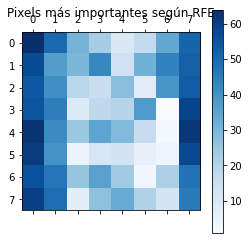

In [87]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Cargamos los datos en "X" e "y":
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Creamos el objeto RFE y lo utilizamos para rankear la importancia de cada pixel:
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Graficamos este ranking:
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Pixels más importantes según RFE")
plt.show()

In [107]:
# Cargamos los datos en "X" e "y":
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Creamos el objeto RFE y lo utilizamos para rankear la importancia de cada pixel:
svc = SVC(kernel="linear", C=1)
n_feature = 1
pipe = make_pipeline(StandardScaler(), RFE(estimator=svc, n_features_to_select=n_feature, step=1))

print('SVC: ', cross_val_score(pipe, X, y, scoring='accuracy', cv=5).mean())

SVC:  0.2353915196533581


In [111]:
pd.DataFrame({'rank': rfe.ranking_, 'variable': digits.feature_names}).sort_values(by="rank", ascending=True)

,rank,variable
58,1,pixel_7_2
42,1,pixel_5_2
38,1,pixel_4_6
21,1,pixel_2_5
4,1,pixel_0_4
53,1,pixel_6_5
30,1,pixel_3_6
46,1,pixel_5_6
45,1,pixel_5_5
26,1,pixel_3_2


In [92]:
rfe.score(X, y)

0.9126321647189761

In [89]:
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=10, step=1)
rfe.fit_transform(X, y).shape

(1797, 10)

In [90]:
X.shape

(1797, 64)

### EJERCICIO

Vuelve a leer el DataFrame del Titanic y crea un modelo que sea capaz de predecir si una persona ha sobrevivido o no. Para ello, realiza lo siguiente:
 1. Modelo regresión logística
 2. Modelo regresión logística con estandarización
 3. Modelo regresión logística con selección de variables basado en varianza
 4. Modelo regresión logística con selección de variables basado en árbol de decisión
 5. Modelo regresión logística con selección de variables basado en árbol de decisión y escalado
 6. Modelo regresión logística con selección de variables basado en RFE
 7. Modelo regresión logística con selección de variables basado en RFE y escalado 

In [178]:
import pandas as pd
df = pd.read_csv("../../../data/titanic.csv", sep='\t')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S


In [177]:
# El que queda de Embarked, lo vamos a rellenar con "S" porque es el mayoritario.
df['Embarked'] = df['Embarked'].fillna('S')

# En Age, vamos a completar los valores nulos con la media de los valores de Age.
df['Age'] = df['Age'].fillna(df['Age'].mean())

# En Pclass, vamos a convertirlo a string para luego hacer el One Hot Encoding.
df['Pclass'] = df['Pclass'].astype(str)

# Separamos las variables que podemos utilizar para predecir de la que queremos predecir:
y_col = 'Survived'
X_cols = [col for col in df.columns if col not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']]

X = df[X_cols]
y = df[y_col]

# Tratamiento categóricas:
X = pd.get_dummies(X)

In [191]:
pipe1 = make_pipeline(StandardScaler(), log_reg)
pipe1

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [193]:
pipe1.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [194]:
pipe1.score(X, y)

0.8333333333333334

In [190]:
# 1. Modelo regresión logística
log_reg = LogisticRegression(max_iter=1000)

print("neg_log_loss: " + str(cross_val_score(log_reg, X, y, scoring="neg_log_loss", cv=5).mean()))
print("accuracy: " + str(cross_val_score(log_reg, X, y, scoring="accuracy", cv=5).mean()))

neg_log_loss: -0.4759212214042864
accuracy: 0.794758064516129


In [195]:
# 2. Modelo regresión logística con estandarización
pipe1 = make_pipeline(StandardScaler(), log_reg)

print("neg_log_loss: " + str(cross_val_score(pipe1, X, y, scoring="neg_log_loss", cv=5).mean()))
print("accuracy: " + str(cross_val_score(pipe1, X, y, scoring="accuracy", cv=5).mean()))

neg_log_loss: -0.479496273974297
accuracy: 0.7947580645161292


In [202]:
# 3. Modelo regresión logística con selección de variables basado en varianza
pipe2 = make_pipeline(VarianceThreshold(0.8), log_reg)

print("neg_log_loss: " + str(cross_val_score(pipe2, X, y, scoring="neg_log_loss", cv=5).mean()))
print("accuracy: " + str(cross_val_score(pipe2, X, y, scoring="accuracy", cv=5).mean()))

neg_log_loss: -0.6533363956417058
accuracy: 0.6473790322580644


In [199]:
# Ejemplo de cómo comprobar la varianza de las variables (OJO, puede cambiar en base al muestreo aleatorio en cada CV, por lo que puede 
#generar errores de que ninguna cumpla cierto umbral de varianza)
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)
X_scaled.std(axis=0)

array([0.18642612, 0.21056887, 0.17347059, 0.15326657, 0.39411349,
       0.39411349, 0.48650426, 0.47969966, 0.47969966, 0.40379528,
       0.2763854 , 0.45304688])

In [201]:
# 3. Modelo regresión logística con selección de variables basado en varianza (Variante)
# Si utilizamos un algoritmo de escalado que nos reduzca el rango a algo limitado, podremos obtener mejores resultados, ya que estaríamos 
#reduciendo las variables al mismo rango:
pipe2b = make_pipeline(MinMaxScaler(), VarianceThreshold(0.2), log_reg)

print("neg_log_loss: " + str(cross_val_score(pipe2b, X, y, scoring="neg_log_loss", cv=5).mean()))
print("accuracy: " + str(cross_val_score(pipe2b, X, y, scoring="accuracy", cv=5).mean()))

neg_log_loss: -0.4722446605707463
accuracy: 0.8076612903225806


In [203]:
# 4. Modelo regresión logística con selección de variables basado en árbol de decisión
arb_dec = DecisionTreeClassifier(max_depth=3)
pipe3 = make_pipeline(SelectFromModel(estimator=arb_dec), log_reg)

print("neg_log_loss: " + str(cross_val_score(pipe3, X, y, scoring="neg_log_loss", cv=5).mean()))
print("accuracy: " + str(cross_val_score(pipe3, X, y, scoring="accuracy", cv=5).mean()))

neg_log_loss: -0.4784018805081036
accuracy: 0.8076612903225806


In [206]:
# 5. Modelo regresión logística con selección de variables basado en árbol de decisión y escalado
arb_dec = DecisionTreeClassifier(max_depth=3)
pipe4 = make_pipeline(StandardScaler(), SelectFromModel(estimator=arb_dec), log_reg)

print("neg_log_loss: " + str(cross_val_score(pipe4, X, y, scoring="neg_log_loss", cv=5).mean()))
print("accuracy: " + str(cross_val_score(pipe4, X, y, scoring="accuracy", cv=5).mean()))

neg_log_loss: -0.47538610493236944
accuracy: 0.8076612903225806


In [212]:
s = SelectFromModel(estimator=arb_dec)
s.fit(X, y)

SelectFromModel(estimator=DecisionTreeClassifier(max_depth=3))

In [224]:
# 6. Modelo regresión logística con selección de variables basado en RFE:
rfe = RFE(estimator=log_reg, n_features_to_select=1, step=1)

print("neg_log_loss: " + str(cross_val_score(rfe, X, y, scoring="neg_log_loss", cv=5).mean()))
print("accuracy: " + str(cross_val_score(rfe, X, y, scoring="accuracy", cv=5).mean()))

neg_log_loss: -0.4817756117425859
accuracy: 0.8076612903225806


In [173]:
# 7. Modelo regresión logística con selección de variables basado en árbol de decisión y escalado
arb_dec = DecisionTreeClassifier(max_depth=3)
pipe6 = make_pipeline(StandardScaler(), RFE(estimator=log_reg, n_features_to_select=1, step=1))

print("neg_log_loss: " + str(cross_val_score(pipe6, X, y, scoring="neg_log_loss", cv=5).mean()))
print("accuracy: " + str(cross_val_score(pipe6, X, y, scoring="accuracy", cv=5).mean()))

neg_log_loss: -0.4845469557369156
accuracy: 0.8076612903225806
